# Build predictive model of estradiol level 

In [406]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # For scaling features
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb # For XGBoost model
import shap # For SHAP values

## Load data

In [407]:
# load muscle data
data = pd.read_csv('../result/muscle/estrogen_vst_all_genes.csv', index_col=1)
data.index.name = None
data = data.drop(columns=['Unnamed: 0'])
data = data.T
data.head()

,TSPAN6,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,NIPAL3,...,SCARNA2,MYO19,GGNBP2,DHRS11,ACACA,C11orf98,MRPL45,PWAR5,LOC102724023,UCKL1-AS1
8,7.308610,8.598130,8.193626,6.948367,6.515825,8.322293,7.610520,8.401899,8.631372,7.948255,...,5.643153,7.464141,9.678412,7.918057,9.037855,7.563538,9.349230,8.414737,7.911936,6.535658
11,7.832018,9.021143,8.372626,6.886511,6.458043,8.754189,7.618809,8.152298,8.193220,8.183103,...,5.424117,7.927105,9.599668,8.072129,8.327613,7.539322,9.397582,8.858309,8.072129,6.500161
13,7.323141,8.483794,8.495975,7.201146,6.434678,8.404084,7.222338,8.570759,8.324130,8.253803,...,5.734481,7.761620,9.552024,8.253803,8.819605,7.370638,9.499135,8.450783,8.133283,6.632350
2,7.192163,8.705015,8.298865,6.782854,6.113644,9.598461,7.602433,8.596141,8.151303,8.103775,...,5.804291,7.700129,9.638936,7.907676,8.841418,7.554765,9.644368,8.802837,8.340237,6.719187
53,7.254636,8.964913,8.118994,6.913099,6.539516,9.126759,7.742160,8.145291,8.583897,7.937573,...,5.643949,7.713810,9.302217,7.961614,9.044018,7.713810,9.408259,8.914645,7.578120,6.668275


In [408]:
data.shape

(36, 11732)

In [409]:
data.columns = data.columns.astype(str)

In [410]:
# load muscle metadata
metadata = pd.read_csv('../result/muscle/estrogen_clinical_data.csv', index_col=0)
metadata.head()

,sex,age,estradiol,Total.Testosterone...ng.dL.,group
8,F,O,5.1,12.0,low
11,F,Y,3.2,17.0,low
13,F,Y,5.2,23.0,low
2,F,Y,128.0,18.0,high
53,F,O,72.0,19.0,high


In [411]:
metadata.shape

(36, 5)

In [412]:
# mapping groups to nunmeric values
metadata['category'] = metadata['group'].map({'low': 0, 'high': 1})
metadata.head()

,sex,age,estradiol,Total.Testosterone...ng.dL.,group,category
8,F,O,5.1,12.0,low,0
11,F,Y,3.2,17.0,low,0
13,F,Y,5.2,23.0,low,0
2,F,Y,128.0,18.0,high,1
53,F,O,72.0,19.0,high,1


In [413]:
# check whether the samples in the metadata match the samples in the data
data.index == metadata.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## Exploratory data analysis

In [414]:
# Scale the data for PCA and t-SNE
data_scaled = StandardScaler().fit_transform(data)

In [415]:
# Prepare the first 2 PCA components and plot
pca_2c = PCA(n_components = 2)
pca_2c_features = pca_2c.fit_transform(data_scaled)

pca_2c_df = pd.DataFrame(
    data = pca_2c_features, 
    columns = ['PC1', 'PC2'])

target = list(metadata['group'])
sample_ids = [x+'-'+str(y) for x,y in zip(list(metadata.index),metadata['estradiol'])]
pca_2c_df['sample_id'] = sample_ids

pca_2c_df['target'] = target

expl_var = round(sum(pca_2c.explained_variance_ratio_) * 100, 2)

pca1_expl_var = round(pca_2c.explained_variance_ratio_[0] * 100, 2)
pca2_expl_var = round(pca_2c.explained_variance_ratio_[1] * 100, 2)

x_title = "PC1 (" + str(pca1_expl_var) + "%)"
y_title = "PC2 (" + str(pca2_expl_var) + "%)"

sub_title = "(Explained variance for PC1 and PC2 : " + str(expl_var) + "%)"
title = "PCA Plot \n" + sub_title

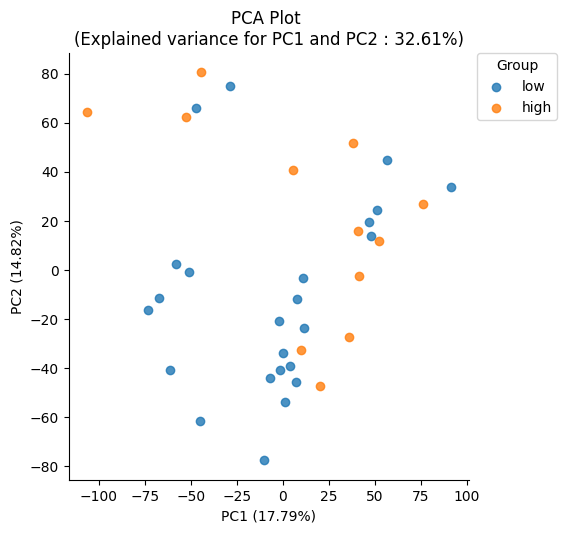

In [416]:
# Plot the first 2 PCA components

sns.lmplot(
    x = 'PC1', 
    y = 'PC2',
    data = pca_2c_df,
    hue = 'target',
    fit_reg = False,
    legend = False
)
plt.title(title)
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Group')
plt.xlabel(x_title)
plt.ylabel(y_title)
plt.show()

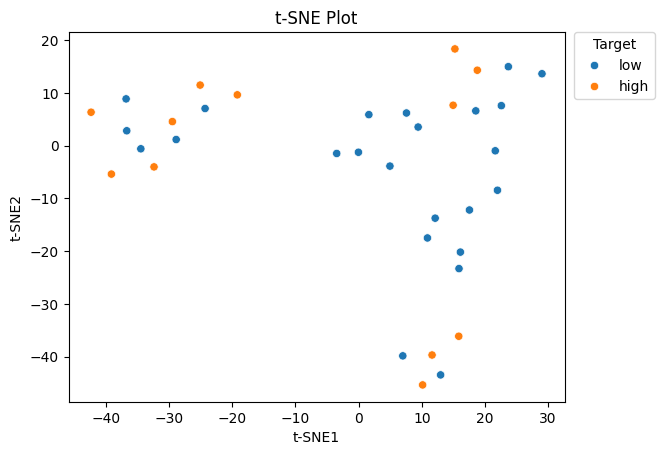

In [417]:
# t-SNE plot
tsne = TSNE(random_state=0, perplexity=5)  # Set perplexity to a value less than n_samples
tsne_results = tsne.fit_transform(data_scaled)
tsne_results = pd.DataFrame(tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_results['target'] = target
tsne_results['sample_id'] = sample_ids

sns.scatterplot(data=tsne_results, 
                x="t-SNE1", 
                y="t-SNE2",
                hue='target',
                legend=True
               )
plt.title('t-SNE Plot')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Target')
plt.show()

## Overlapping genes between muscle and PBMC dataset and creating new data base on overlapping genes

In [418]:
muscle_genes = data.columns.tolist()
len(muscle_genes)

11732

In [419]:
# load PBMC data
pbmc_data = pd.read_csv('../result/pbmc/estrogen_vst_all_genes.csv', index_col=1)
pbmc_data.index.name = None
pbmc_data = pbmc_data.drop(columns=['Unnamed: 0'])
pbmc_data = pbmc_data.T
pbmc_data.head()


,TSPAN6,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,MYG1,HAT1,SLC25A12,LOC124905558,LOC102724250,MROH8,GPATCH4,LOC124906262,CCL3L3,LOC131768270
RS08,6.175721,9.011541,8.659673,7.143139,13.560706,6.128733,10.405499,9.676569,9.849280,7.038034,...,9.486630,9.142210,8.772843,6.430081,7.186811,6.146253,8.907415,7.030667,6.010690,10.567538
RS09,6.008923,8.890049,8.925649,7.257880,13.517049,6.554040,9.669880,10.026347,10.082151,6.986369,...,9.298063,9.571433,8.893881,6.494794,7.256906,5.823909,9.249821,8.054825,5.899513,10.339655
RS27,5.852890,9.417997,8.920907,7.822868,13.693354,6.420919,10.302389,9.974205,9.944402,6.668784,...,9.219452,10.077596,8.739547,6.266393,7.271585,6.252593,8.597235,7.848703,6.318096,10.012374
RS23,6.339482,9.212254,9.134315,7.206436,13.337016,6.661901,10.145360,9.889881,10.148526,7.069168,...,9.545868,9.814210,5.292656,7.809999,7.499181,6.075832,8.827199,7.912863,6.616653,10.190870
RS02,6.176475,9.053602,8.748565,7.068251,13.317331,6.633158,10.023002,9.365398,9.818509,7.000418,...,9.572990,9.303400,8.896677,6.634207,6.464575,5.932100,8.759437,7.703309,6.309501,10.502462


In [420]:
pbmc_data.shape

(8, 13343)

In [421]:
pbmc_genes = pbmc_data.columns.tolist()
len(pbmc_genes)

13343

In [422]:
overlapping_genes = list(set(muscle_genes).intersection(pbmc_genes))
len(overlapping_genes)

10176

In [423]:
muscle_data_filtered = data.loc[:, overlapping_genes]
pbmc_data_filtered = pbmc_data.loc[:, overlapping_genes]
muscle_data_filtered.shape, pbmc_data_filtered.shape

((36, 10176), (8, 10176))

## Train Test Split

In [424]:
# Assign response, and split data for train and test
y =  metadata["category"]
X_train, X_test, y_train, y_test = train_test_split(muscle_data_filtered,
                                                    y,
                                                    test_size = 0.3, 
                                                    random_state = 44)   
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (25, 10176)
X_test shape (11, 10176)


## XGBoost

In [425]:
# Initiate and train the model
dtrain = xgb.DMatrix(X_train, label=y_train.values)
dtest = xgb.DMatrix(X_test, label=y_test.values)
param = {'max_depth': 10,                       #  this has to be optimised for your model, range between 0->
         'eta': 0.5,                           #  this has to be optimised for your model, range between 0-1
         'objective': 'binary:logistic',       #  this depends on the nature of your model
        }

param['eval_metric'] = 'auc'                   #  this depends on the objective 
num_round = 100                                # number of rounds for boosting
evallist = [(dtest, 'eval'),(dtrain, 'train')] # eval test
progress = {}
model = xgb.train(param, dtrain, num_round, 
                        
                     evals=evallist, evals_result = progress, 
                     verbose_eval=5, 
                     early_stopping_rounds=20) 

# classes in y_test
print(" ")
print("bincount y_test:", np.bincount(y_test))

[0]	eval-auc:0.80556	train-auc:0.98000
[5]	eval-auc:1.00000	train-auc:1.00000
[10]	eval-auc:0.94444	train-auc:1.00000
[15]	eval-auc:0.94444	train-auc:1.00000
[20]	eval-auc:0.94444	train-auc:1.00000
 
bincount y_test: [9 2]


In [426]:
# Generate test predictions and assign to the nearest classification
preds = model.predict(dtest)
prediction =[]
for i in preds:
    if i >=0.5:
        prediction.append(1)
    else:
        prediction.append(0)
print("bincount prediction:", np.bincount(prediction))

bincount prediction: [7 4]


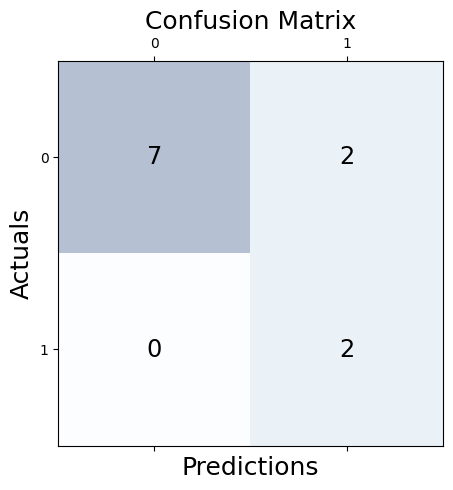

In [427]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [428]:
# Scores

print('Accuracy: %.3f' % accuracy_score(y_test, prediction))
print('F1 Score (Weighted): %.3f' % f1_score(y_test, prediction, average='weighted'))
print('Precision (Weighted): %.3f' % precision_score(y_test, prediction, average='weighted'))
print('Recall (Weighted): %.3f' % recall_score(y_test, prediction, average='weighted'))

Accuracy: 0.818
F1 Score (Weighted): 0.837
Precision (Weighted): 0.909
Recall (Weighted): 0.818


### ROC curve

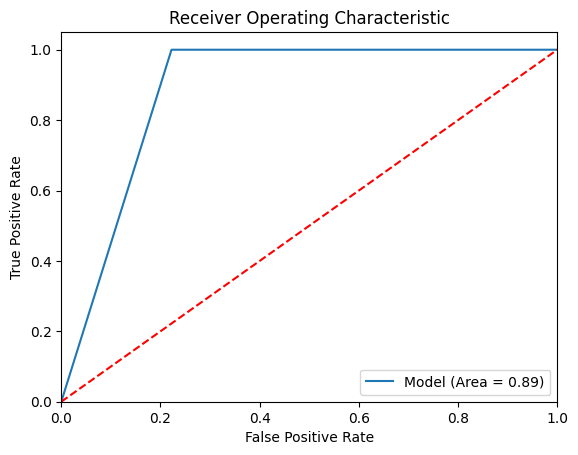

In [429]:
y_true = np.array(y_test.values)
pred_array = np.array(prediction)
muscle_roc = roc_auc_score(y_true, pred_array)

muscle_fpr, muscle_tpr, muscle_thresholds = roc_curve(y_true, pred_array) 
plt.figure()
plt.plot(muscle_fpr, muscle_tpr, label='Model (Area = %0.2f)' % muscle_roc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### SHAP summary plot


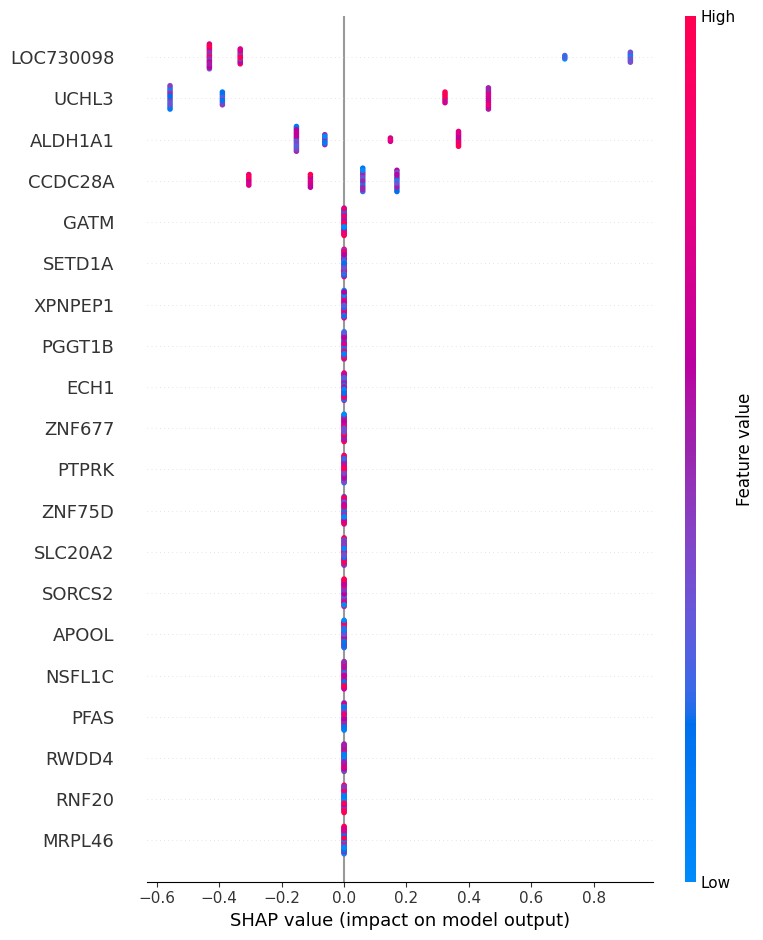

In [430]:
shap.initjs()

# Apply the generated model to the whole dataset and calculate the shap values
shap_values = shap.TreeExplainer(model).shap_values(muscle_data_filtered.values)  
explainer = shap.TreeExplainer(model, muscle_data_filtered.values)
expected_value = explainer.expected_value

features = muscle_data_filtered.columns

# Convert data DF to array
data_ = muscle_data_filtered.to_numpy()

# Run predictions for the whole dataset
d_data = xgb.DMatrix(muscle_data_filtered, label=y.values)

preds_data = model.predict(d_data)
prediction_data =[]
for i in preds_data:
    if i >=0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)

# Print the shap summary plot
shap.summary_plot(shap_values, muscle_data_filtered, feature_names=muscle_data_filtered.columns) 

### SHAP force plot

In [431]:
# A function that displays the actual value, the predicted value and estradiol level
# that is added to the force plot 
# Adapted from Max Steele def shap_force 
# https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

def shap_accuracy(prediction_list, index, y_values, DA_values):
    pred = prediction_list[index]
    
    true_label = y_values[index]
    
    DA = DA_values[index]
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct'
    else:
        accurate = 'Incorrect'
        
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    # print disease activity score
    print(f'Score: {DA}')
    print('***'*12)
    print()

In [432]:
# Rank the estradiol level, and get the positions of the 5 samples
# with the highest estradiol level and the 5 samples with the lowest

DAranking = metadata[['estradiol']]
DAranking.insert(loc=0, column="rowPosition", value=np.arange(len(DAranking))) # column with row position
DAranking = DAranking.sort_values(by = 'estradiol', ascending = False)         # sort estradiol level in descending order
DAranking.insert(loc=0, column="DAorder", value=np.arange(len(DAranking)))     # column with estradiol level order position
DAranking = DAranking.drop(columns="estradiol")

# Get row positions of top 5
positionlist = DAranking["rowPosition"].tolist()
TopDA = positionlist[:5]
print("TOP 5 DA rows", TopDA)

# Get row positions of bottom 5
positionlist.reverse()
BotDA = positionlist[:5]
print("BOTTOM 5 DA rows", BotDA)

# estradiol level into a series        
DA = metadata[['estradiol']]
DA = DA.to_numpy()

TOP 5 DA rows [23, 35, 3, 26, 4]
BOTTOM 5 DA rows [7, 9, 32, 19, 17]


In [433]:
print(prediction_data)
print(y.values.tolist())

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [194.]
************************************



C:\Users\ngduy\AppData\Local\Temp\ipykernel_32984\522342262.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = y_values[index]


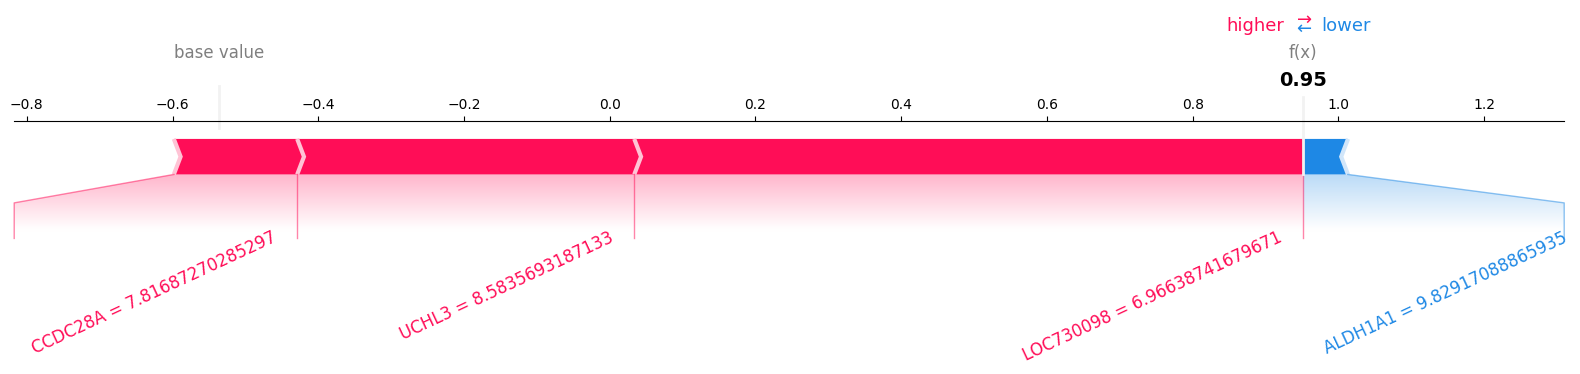

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [144.]
************************************



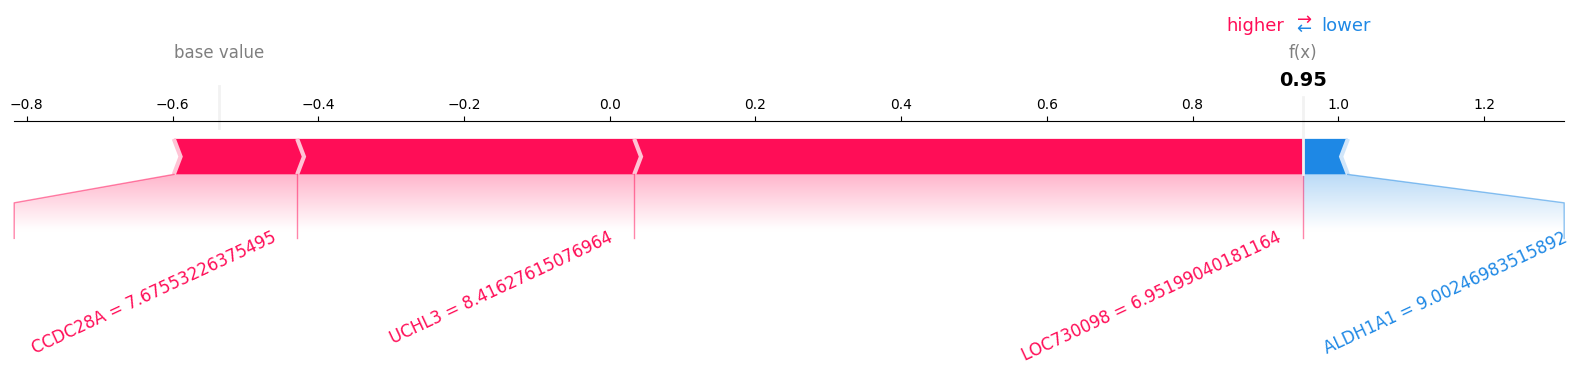

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [128.]
************************************



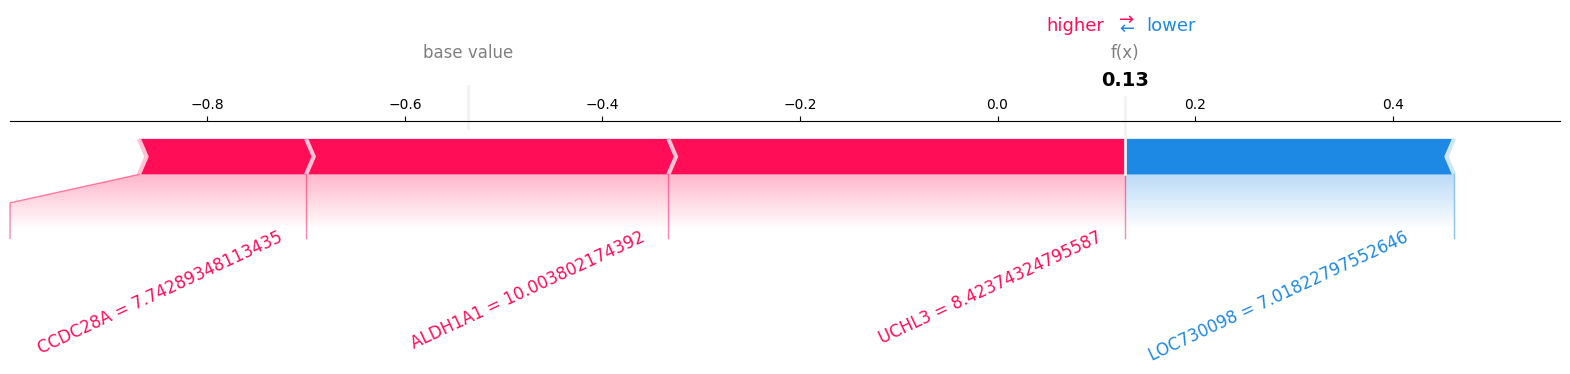

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [86.]
************************************



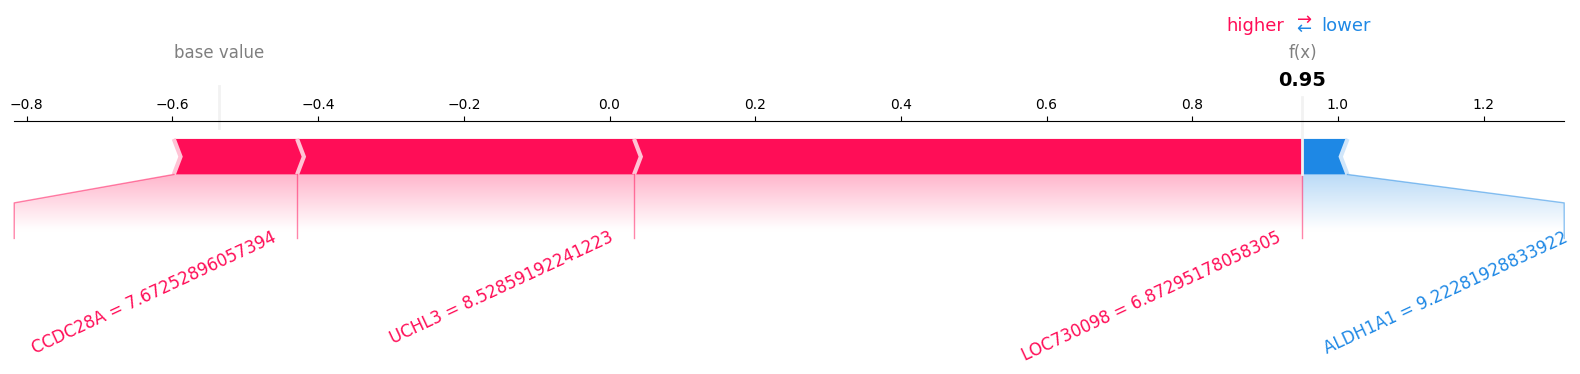

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [72.]
************************************



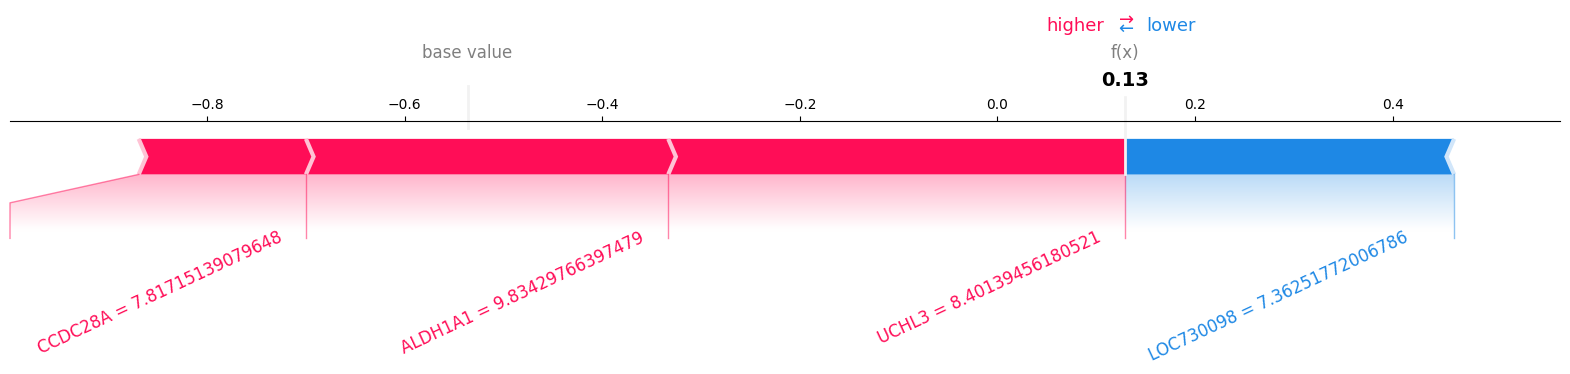

In [434]:
# Force plots for top 5 estradiol level
for i in TopDA:
    shap_accuracy(prediction_data, i, y, DA)
    shap.force_plot(expected_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)

C:\Users\ngduy\AppData\Local\Temp\ipykernel_32984\522342262.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = y_values[index]


************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [1.6]
************************************



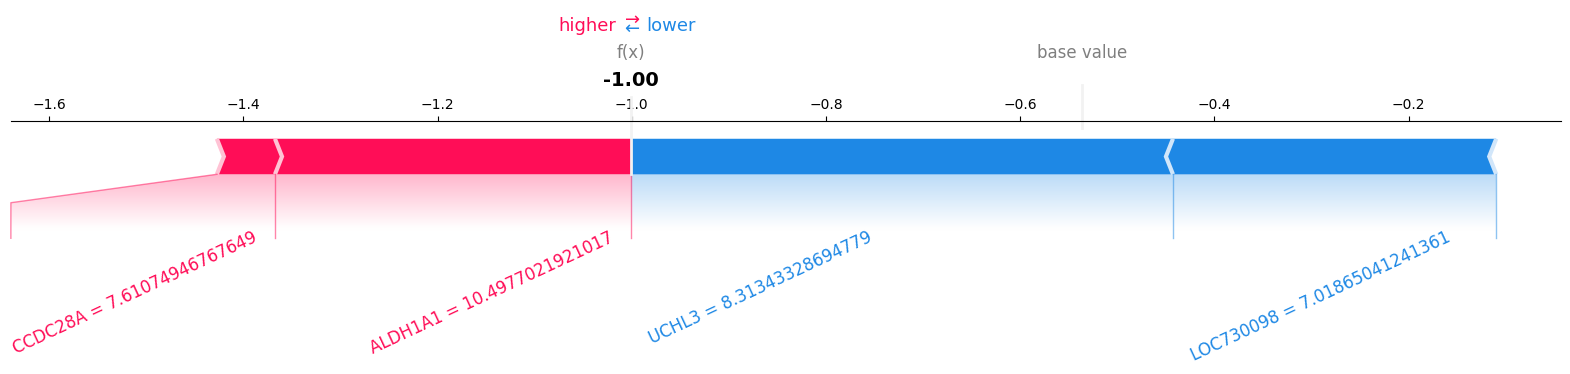

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [1.7]
************************************



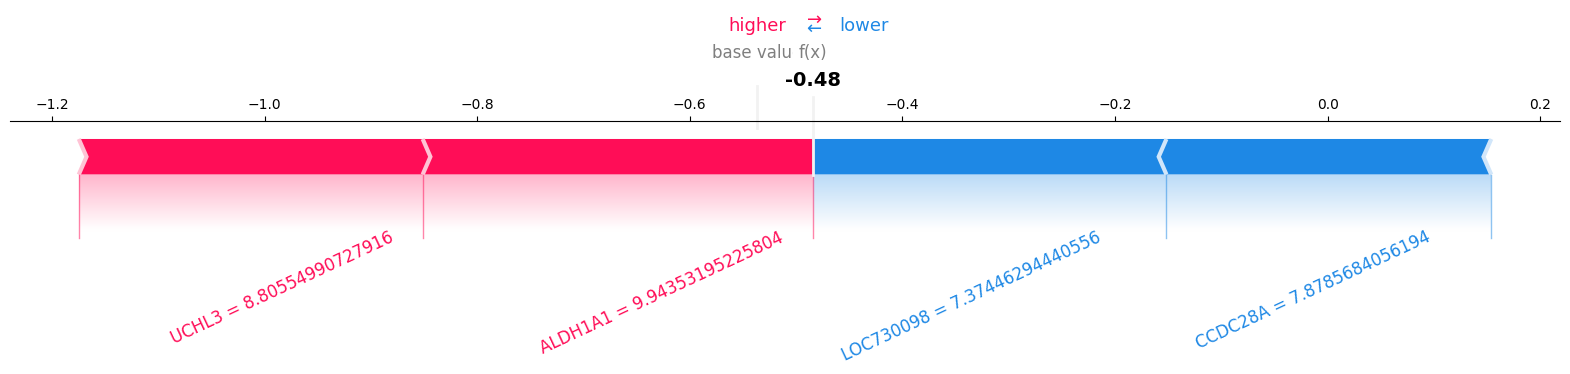

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [1.8]
************************************



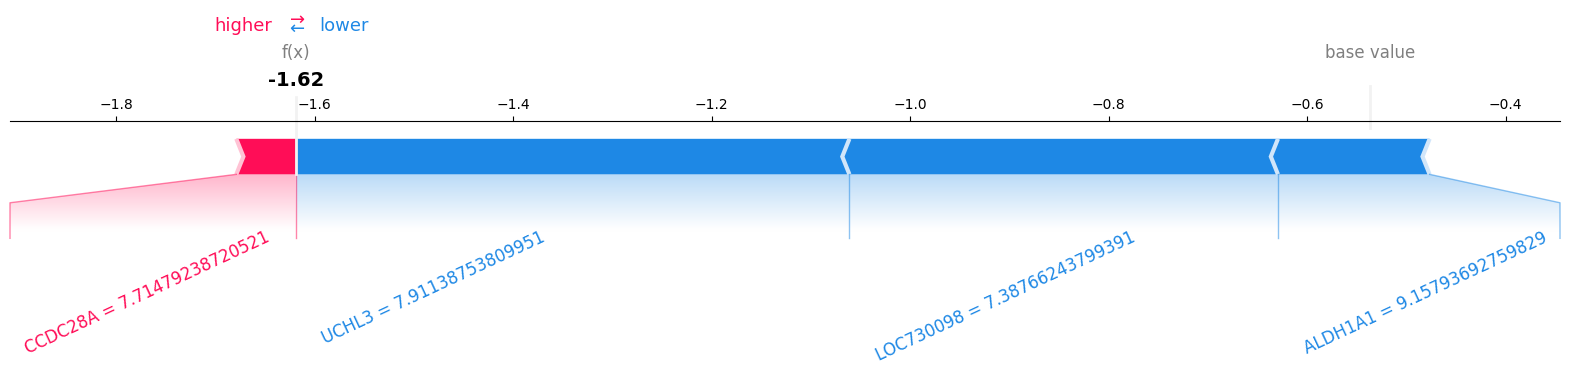

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [1.8]
************************************



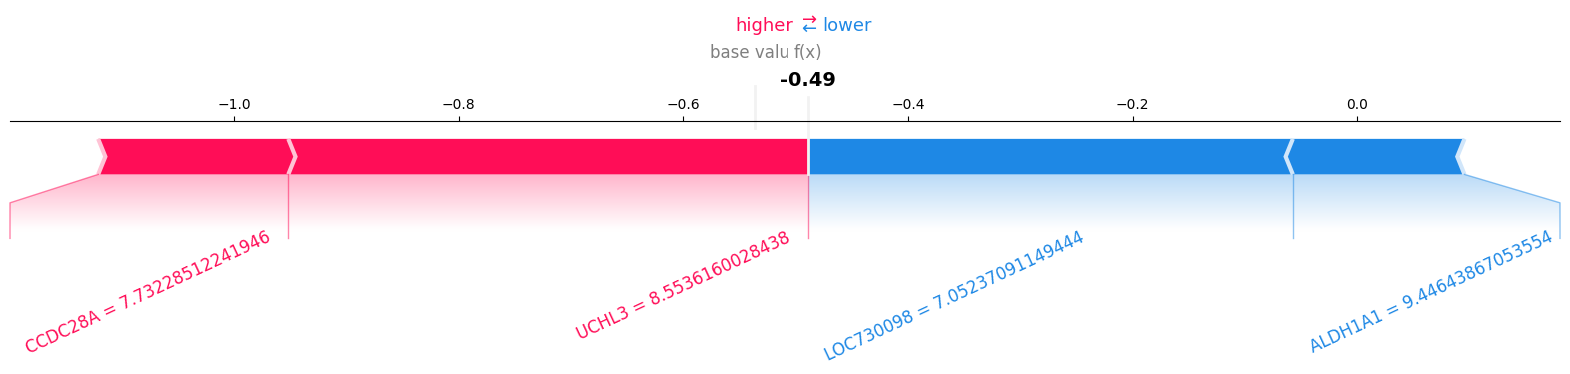

************************************
Ground Truth Label: 0
Model Prediction:  0 -- Correct
Score: [1.9]
************************************



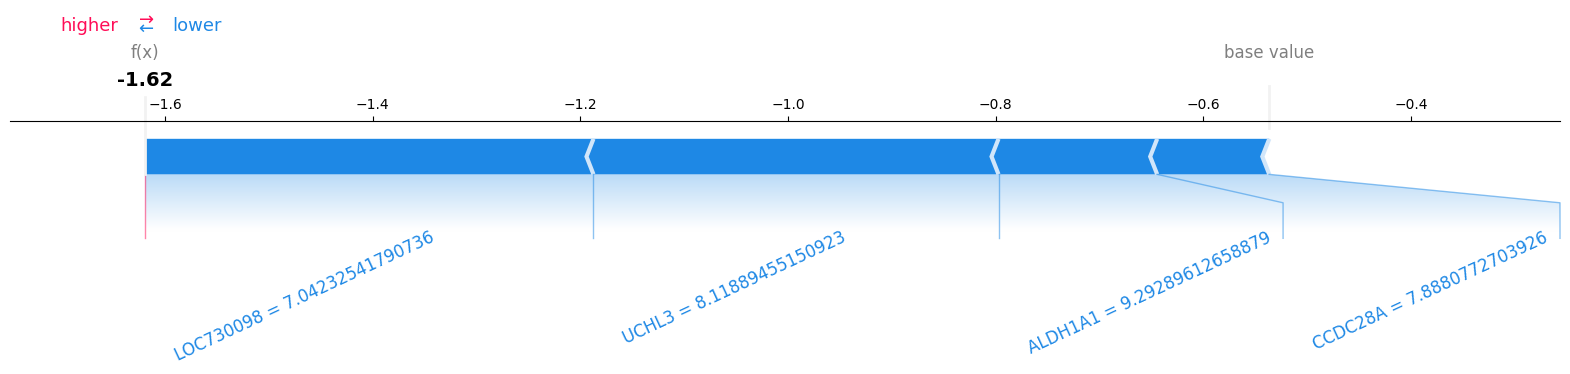

In [435]:
# Force plots for bottom 5 estradiol level
for i in BotDA:
    shap_accuracy(prediction_data, i, y, DA)
    shap.force_plot(expected_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)

## PBMC prediction

In [436]:
# load PBMC metadata
pbmc_metadata = pd.read_csv('../result/pbmc/estrogen_clinical_data.csv', index_col=0)
pbmc_metadata.head()

,sex,age,estradiol,BMI,group
RS08,Female,22,310.789094,19,high
RS09,Female,25,146.542097,22,high
RS27,Female,30,119.031406,22,high
RS23,Female,24,115.762809,27,high
RS02,Female,21,27.783074,22,low


In [437]:
# mapping groups to numeric values
pbmc_metadata['category'] = pbmc_metadata['group'].map({'low': 0, 'high': 1})
pbmc_metadata.head()

,sex,age,estradiol,BMI,group,category
RS08,Female,22,310.789094,19,high,1
RS09,Female,25,146.542097,22,high,1
RS27,Female,30,119.031406,22,high,1
RS23,Female,24,115.762809,27,high,1
RS02,Female,21,27.783074,22,low,0


In [438]:
# check whether the samples in the metadata match the samples in the data
pbmc_data_filtered.index == pbmc_metadata.index

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [439]:
muscle_data_filtered.head()

,PFAS,ALDH1A1,NSFL1C,APOOL,SORCS2,SLC20A2,ZNF75D,PTPRK,ZNF677,CCDC28A,...,RTF1,SHISA5,CDKN2AIP,RNF103-CHMP3,SDHAF4,XPOT,ARHGEF10,IFT22,ABCA3,USP49
8,7.762886,9.808856,10.728042,10.107964,6.143791,11.949334,7.899610,7.936256,7.196557,7.803391,...,11.068477,7.880908,8.173505,9.852934,8.051732,8.872412,7.207177,8.079138,8.218372,7.555540
11,7.497677,9.607113,10.513087,10.552098,6.828822,11.817086,7.914807,8.183103,7.391847,7.908615,...,10.826379,8.162643,8.115466,9.801289,8.115466,8.910661,7.480635,8.515654,8.083092,7.428108
13,7.841968,9.970998,10.662403,10.498870,6.316432,12.055447,8.041048,8.006953,7.222338,7.600385,...,10.894158,8.310346,8.006953,9.779205,8.117450,8.882465,7.303626,8.179719,8.268157,7.342357
2,7.850654,10.003802,10.940451,10.423135,7.305465,11.611059,7.721683,8.065638,7.213557,7.742893,...,10.910781,8.202259,8.236842,9.753931,7.926161,9.044954,7.170384,8.182102,8.371587,7.409302
53,7.790366,9.834298,10.719320,10.187396,6.812813,11.971849,7.894446,8.206431,7.562138,7.817151,...,11.004002,8.134833,8.160832,9.955592,8.070353,8.805185,7.586038,8.206431,8.728355,7.399553


In [440]:
pbmc_data_filtered.head()

,PFAS,ALDH1A1,NSFL1C,APOOL,SORCS2,SLC20A2,ZNF75D,PTPRK,ZNF677,CCDC28A,...,RTF1,SHISA5,CDKN2AIP,RNF103-CHMP3,SDHAF4,XPOT,ARHGEF10,IFT22,ABCA3,USP49
RS08,8.697549,10.495877,9.995057,8.210314,6.569795,8.998087,8.558833,7.050582,7.908216,9.061552,...,10.622897,12.720486,9.612738,6.357603,6.877825,10.126066,6.366449,6.701801,8.259682,7.040886
RS09,8.801041,10.466113,9.948206,8.452485,6.313170,9.207797,9.028370,7.605772,7.484688,8.647013,...,10.856565,12.236002,10.108243,6.266990,7.205679,10.910742,6.834401,6.824023,7.889289,7.984330
RS27,8.673483,11.355924,10.383383,8.258454,5.952289,8.820847,8.864174,7.868166,7.952026,9.353714,...,10.730744,12.055401,9.731061,5.672557,7.394923,10.911094,6.372609,7.138583,7.635934,7.497948
RS23,8.968047,11.026490,10.207946,8.227631,6.505879,9.003078,8.942002,8.029263,7.697173,9.135481,...,10.777211,12.318758,9.618174,6.181604,7.024742,10.612804,6.490489,7.130769,8.031017,7.190065
RS02,9.103009,10.914507,10.262301,8.259506,6.416137,8.995725,8.418568,7.262072,8.197805,8.798561,...,10.583546,12.568081,9.679818,6.146354,7.063704,10.407514,6.326762,6.716194,7.883491,7.578874


In [441]:
pbmc_predict= model.predict(xgb.DMatrix(pbmc_data_filtered,label=pbmc_metadata['category'].to_numpy()))

In [442]:
pbmc_prediction_result = []
for i in pbmc_predict:
    if i >=0.5:
        pbmc_prediction_result.append(1)
    else:
        pbmc_prediction_result.append(0)

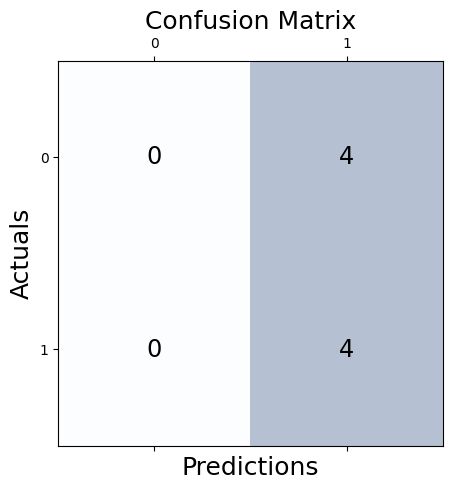

In [443]:
pbmc_conf_matrix = confusion_matrix(y_true = pbmc_metadata['category'].values, y_pred = pbmc_prediction_result)
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(pbmc_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(pbmc_conf_matrix.shape[0]):
    for j in range(pbmc_conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=pbmc_conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [444]:
# Scores
print('Accuracy: %.3f' % accuracy_score(pbmc_metadata['category'], pbmc_prediction_result))
print('F1 Score: %.3f' % f1_score(pbmc_metadata['category'], pbmc_prediction_result, average='weighted'))
print('Precision: %.3f' % precision_score(pbmc_metadata['category'], pbmc_prediction_result, average='weighted'))
print('Recall: %.3f' % recall_score(pbmc_metadata['category'], pbmc_prediction_result, average='weighted'))

Accuracy: 0.500
F1 Score: 0.333
Precision: 0.250
Recall: 0.500


c:\Users\ngduy\Documents\Project\PMBC_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


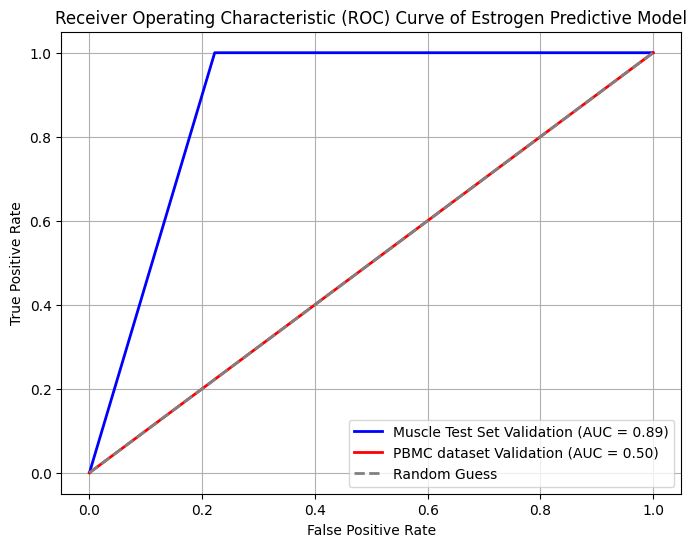

In [445]:
# ROC curve
pbmc_y_true = np.array(pbmc_metadata['category'].values)
pbmc_pred_array = np.array(pbmc_prediction_result)
pbmc_roc = roc_auc_score(pbmc_y_true, pbmc_pred_array)

pbmc_fpr, pbmc_tpr, pbmc_thresholds = roc_curve(pbmc_y_true, pbmc_pred_array)
# plt.figure()
# plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % roc) 
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()
# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(muscle_fpr, muscle_tpr, color='blue', lw=2, label=f'Muscle Test Set Validation (AUC = {muscle_roc:.2f})')
plt.plot(pbmc_fpr, pbmc_tpr, color='red', lw=2, label=f'PBMC dataset Validation (AUC = {pbmc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Estrogen Predictive Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

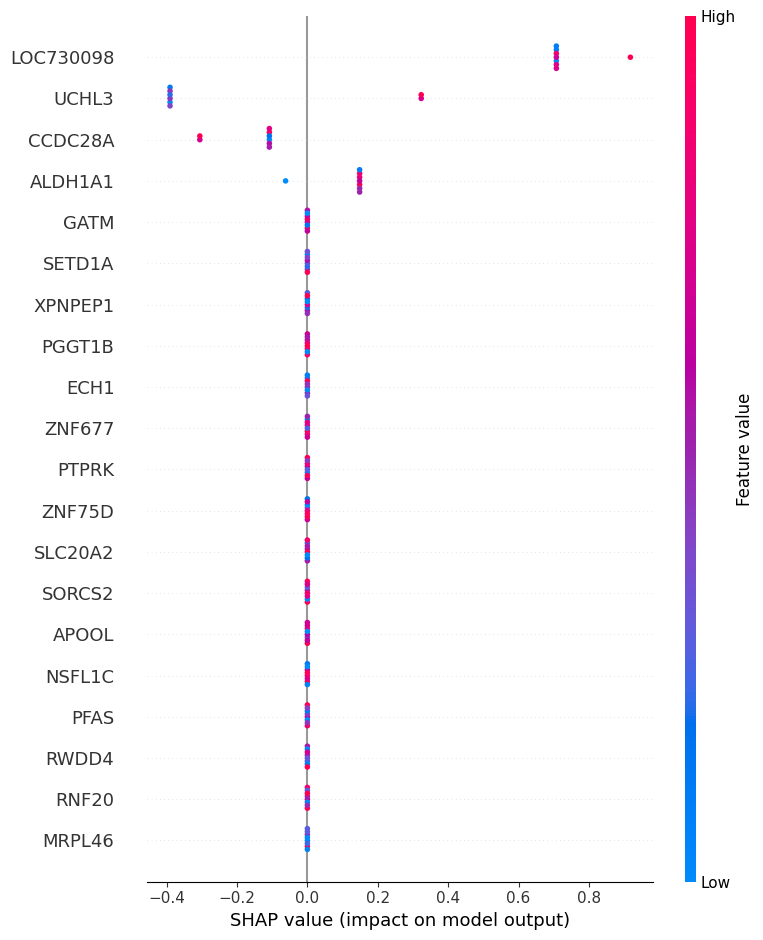

In [446]:
shap.initjs()

# Apply the generated model to the whole dataset and calculate the shap values
pbmc_shap_values = shap.TreeExplainer(model).shap_values(pbmc_data_filtered.values)  
pbmc_explainer = shap.TreeExplainer(model, pbmc_data_filtered.values)
pbmc_expected_value = explainer.expected_value

features = pbmc_data_filtered.columns

# Convert data DF to array
pbmc_data_ = pbmc_data_filtered.to_numpy()

# Run predictions for the whole dataset
pbmc_d_data = xgb.DMatrix(pbmc_data_filtered, label=pbmc_metadata['category'].to_numpy())

preds_data = model.predict(pbmc_d_data)
prediction_data =[]
for i in preds_data:
    if i >=0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)

# Print the shap summary plot
shap.summary_plot(pbmc_shap_values, pbmc_data_filtered, feature_names=pbmc_data_filtered.columns) 

In [447]:
# Rank the clinical data by estradiol level, and get the positions of the 5 samples
# with the highest estradiol level and the 5 samples with the lowest 

DAranking = pbmc_metadata[['estradiol']]
DAranking.insert(loc=0, column="rowPosition", value=np.arange(len(DAranking))) # column with row position
DAranking = DAranking.sort_values(by = 'estradiol', ascending = False)         # sort estradiol level in descending order
DAranking.insert(loc=0, column="DAorder", value=np.arange(len(DAranking)))     # column with estradiol level order position
DAranking = DAranking.drop(columns="estradiol")

# Get row positions of top 4
positionlist = DAranking["rowPosition"].tolist()
TopDA = positionlist[:4]
print("TOP 4 DA rows", TopDA)

# Get row positions of bottom 4
positionlist.reverse()
BotDA = positionlist[:4]
print("BOTTOM 4 DA rows", BotDA)

# estradiol level into a series        
DA = metadata[['estradiol']]
DA = DA.to_numpy()


TOP 4 DA rows [0, 1, 2, 3]
BOTTOM 4 DA rows [7, 6, 5, 4]


In [448]:
print(pbmc_y_true.tolist())
print(prediction_data)

[1, 1, 1, 1, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1]


************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [5.1]
************************************



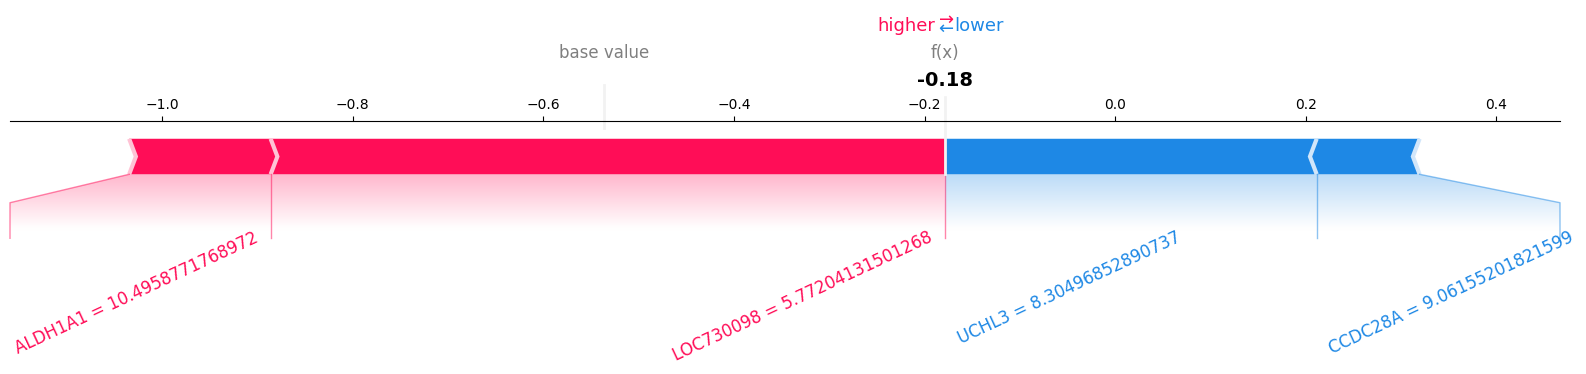

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [3.2]
************************************



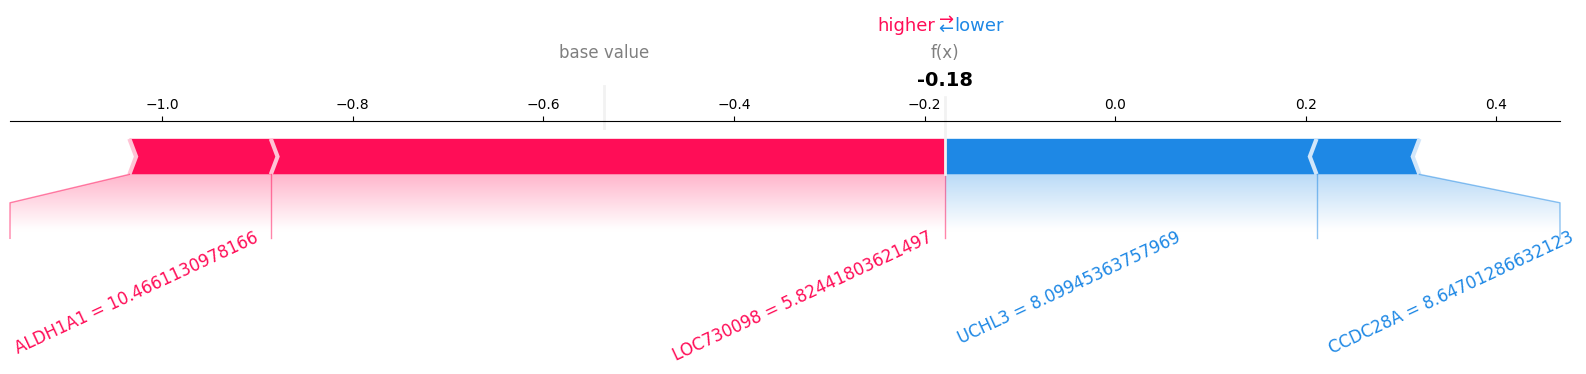

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [5.2]
************************************



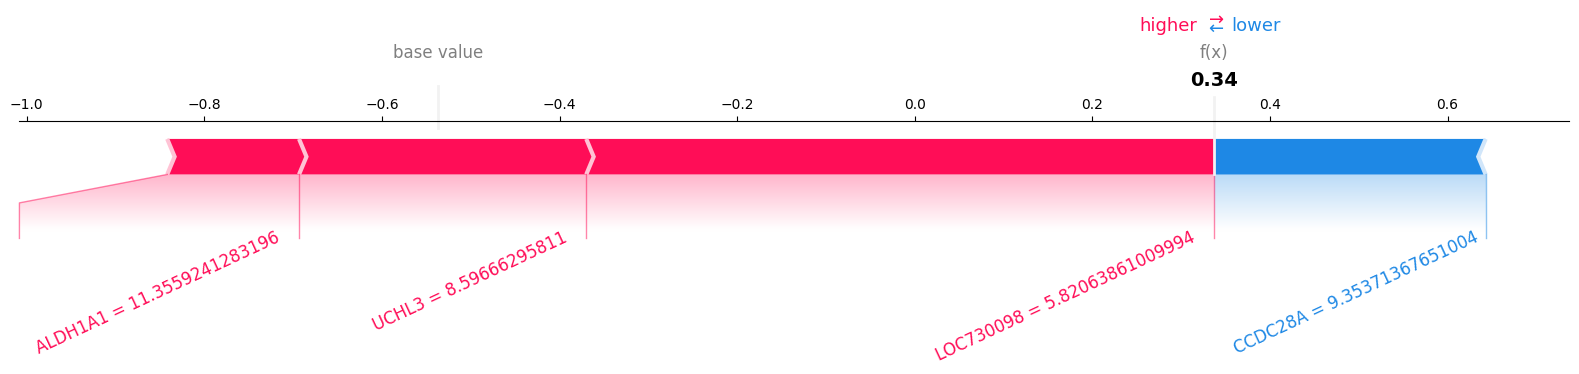

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
Score: [128.]
************************************



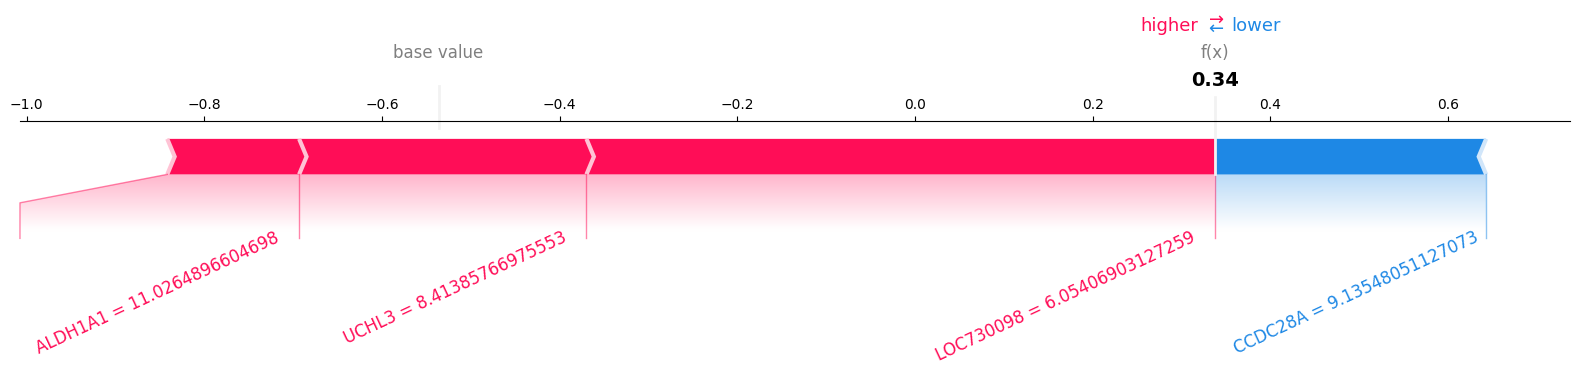

In [449]:
# Force plots for top 4 estradiol level
for i in TopDA:
    shap_accuracy(prediction_data, i, pbmc_y_true, DA)
    shap.force_plot(pbmc_expected_value, pbmc_shap_values[i], pbmc_data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [1.6]
************************************



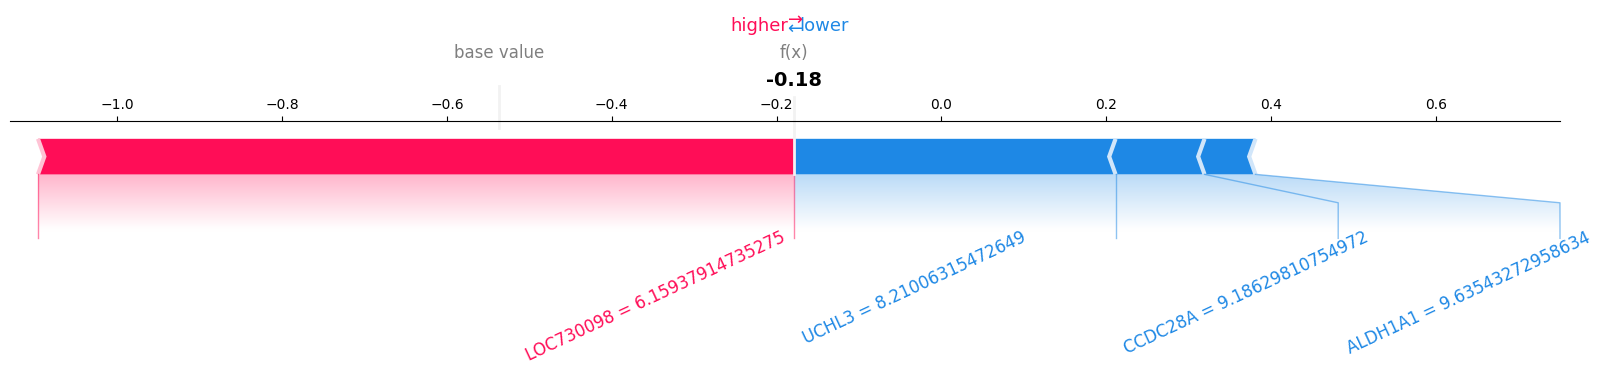

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [3.3]
************************************



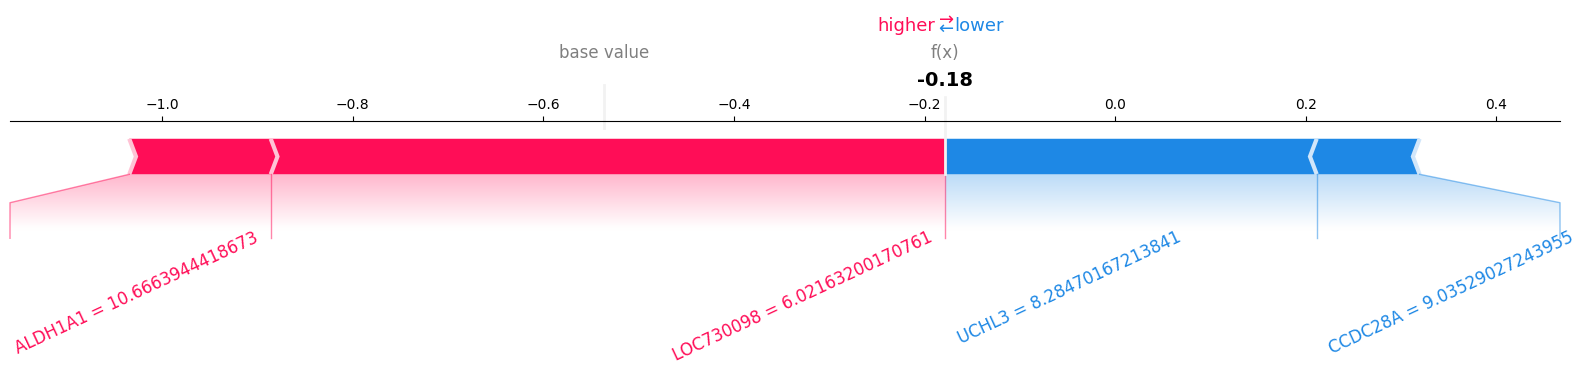

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [5.]
************************************



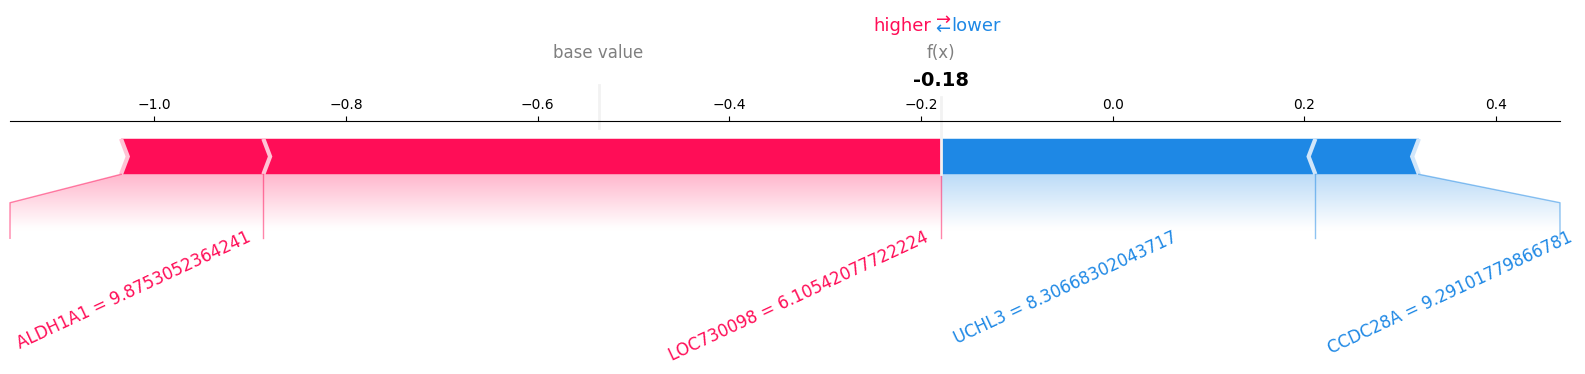

************************************
Ground Truth Label: 0
Model Prediction:  1 -- Incorrect
Score: [72.]
************************************



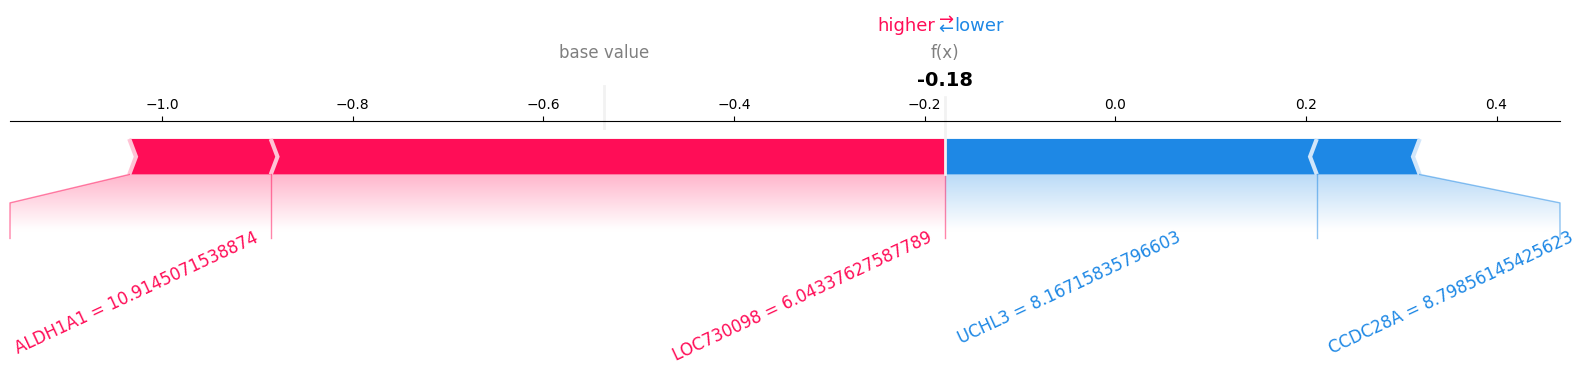

In [450]:
# Force plots for bottom 4 estradiol level
for i in BotDA:
    shap_accuracy(prediction_data, i, pbmc_y_true, DA)
    shap.force_plot(pbmc_expected_value, pbmc_shap_values[i], pbmc_data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)